<a href="https://colab.research.google.com/github/akshaypt7/amazon_sales_prediction/blob/main/project_01_06_embedding_using_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 6.8 MB/s 
     |████████████████████████████████| 46 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 16.1 MB/s 
     |████████████████████████████████| 188 kB 39.7 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 344 kB/s 
Mounted at /content/gdrive


In [23]:
#hide
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
# from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [2]:
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers import Dense, Flatten, Dropout, Input, Embedding, Reshape
from keras.layers import concatenate
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

from sklearn.model_selection import train_test_split
import math
import pandas as pd

In [30]:

#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [31]:
#hide
from fastbook import *

What do you plan to do now,

The idea is to try out embedding using fast ai.

For that first we would have to create the model ourselves to create the embeddings.

We would have to create the model using nn.Sequential on how it created the model in collab filtering, we would have to concat the embeddings.

But there are certain questions we might have to answer. such as what we will train on, that would be y-quantity. 


Then we would have to get the embedding from the model, and then save it and pass it into main_data, remember it will be in the form of list, we might be able to use the function in the last part.

**May be we can try dot product of two of our embedding (how google play is built**

In [20]:
infile = open('/content/gdrive/MyDrive/bluebook/df_main.pkl','rb')
df_main = pickle.load(infile)

In [ ]:
df_main.head()

,date,Asin,Item Promo Discount,price,hour,Quantity,Invoice Amount
0,2021-01-04,B07KYFHTGF,0.00,1995.00,12.0,1.0,1995.00
1,2021-01-08,B07TM3LRVB,-56.75,1078.25,20.0,1.0,1078.25
2,2021-01-09,B08976V1BZ,-79.95,1519.05,22.0,1.0,1519.05
3,2021-01-11,B07TM3LRVB,0.00,1135.00,10.0,1.0,1135.00
4,2021-01-12,B08332221J,0.00,1499.00,12.0,1.0,1499.00


In [32]:
df_main = add_datepart(df_main,'date')

In [33]:
procs = [Categorify, FillMissing, Normalize]

We are changing the category variables and continous variables, because we think when we apply entity embedding, we get more value from these variables. (so we don't add quanity in both cat and cont)

In [34]:
cat = ['Asin',
 'hour',
 'Dayofweek',
 'Month',
 'Day',
 'Week',
 'Year',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [35]:
cont = ['Item Promo Discount',
 'price',
 'Invoice Amount',
 'Dayofyear',
 'Elapsed']

In [36]:
# SPLITS 
condition = (df_main.Year < 2020) | (df_main.Month < 8)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [37]:
splits = (list(train_idx),list(valid_idx))

In [38]:
dep_var = 'Quantity'

In [39]:
to_emb = TabularPandas(df_main,procs= procs, cat_names=cat, cont_names = cont, y_names=dep_var, splits = splits)

In [40]:
to_emb.items.head(2)

,Asin,Item Promo Discount,price,hour,...,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2,0.393801,1.289015,13,...,1,1,1,0.704794
1,8,-1.607343,-0.424478,21,...,1,1,1,0.724514


In [41]:
x_train = to_emb.train.xs
y_train = to_emb.train.ys

x_valid = to_emb.valid.xs
y_valid = to_emb.valid.ys

In [42]:
upper_limit =max(df_main[dep_var].values)
lower_limit =min(df_main[dep_var].values)
upper_limit, lower_limit


(39.0, 1.0)

In [43]:
dls_emb = to_emb.dataloaders(bs=256)

In [44]:
learner_emb = tabular_learner(dls_emb,y_range= (1,39), layers= [250,100],n_out =1,loss_func= F.mse_loss, metrics=nn.L1Loss())

SuggestedLRs(valley=0.001737800776027143)

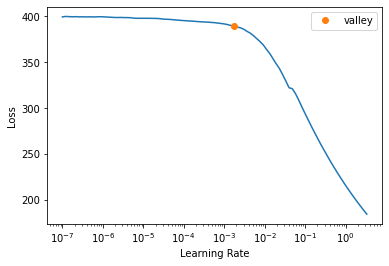

In [ ]:
learner_emb.lr_find()

In [45]:
learner_emb.fit(7,lr=1e-2)

epoch,train_loss,valid_loss,None,time
0,134.235031,11.277607,0.997936,00:00
1,59.621895,4.548239,0.902090,00:00
2,33.314564,2.288091,0.597900,00:00
3,18.700476,0.789212,0.482576,00:00
4,10.198370,0.358303,0.423754,00:00
5,5.742817,0.277907,0.327106,00:00
6,3.389683,0.339596,0.381029,00:00


Training with weight decay and without have a huge impact in the loss

In [58]:
learner_emb.fit(7,lr=1e-2,wd=0.01)

epoch,train_loss,valid_loss,None,time
0,121.911285,2.662129,0.821382,00:00
1,57.037003,21.404379,1.088229,00:00
2,35.338722,0.399664,0.430365,00:00
3,20.743139,0.348871,0.454211,00:00
4,13.084545,0.238974,0.310623,00:00
5,7.328192,0.289073,0.397446,00:00
6,4.189364,0.606473,0.308012,00:00


In [ ]:
preds, targs = learner_emb.get_preds()

In [ ]:
MAE(targs,preds)

0.3210282

**MAE is 0.32**

### Now we need to get the embeddings from the learner

In [47]:
import torch


# Just right before the actual usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Creating Dataframe which will have all the embeddings

In [ ]:
embedding_cols = ['Asin','hour','Dayofweek','Month','Day','Week','Year']

Instead of just the above columns, we decide to get embedding for all categories

In [ ]:


index = output.data.numpy().argmax()

index = output.cpu().data.numpy().argmax()

In [48]:
new_df = pd.DataFrame()

for i,col in enumerate(cat):
  embedding = learner_emb.model.embeds[i]

  to_emb.items[col] = torch.tensor(to_emb.items[col].values).to(device).long()

  new_column = embedding(tensor(to_emb.items[col]))
  new_column = new_column.detach().numpy()


  

  for e_dim in range(embedding.embedding_dim):
    new_df[col+f'_{e_dim}'] = new_column[:,e_dim]

TypeError: ignored

In [37]:
new_df.shape # there are total 63 embeddings

(10946, 81)

##### Merging the dataframes

In [39]:
df = df_main.copy()
for col in new_df.columns:
  df[col] = new_df[col]

for old_columns in cat:
  df.drop(old_columns,axis=1,inplace=True)

##### Save the Dataframe with embeddings



In [40]:
# save_pickle('/content/gdrive/MyDrive/bluebook/df_with_embeddings.pkl',df)

In [4]:
import pickle

In [17]:
def open_test_data():
    return open('/content/drive/MyDrive/bluebook/df_with_embeddings.pkl', 'rb')

with open_test_data() as f:
    df = pickle.load(f) 

In [3]:
# df= load_pickle('/content/gdrive/MyDrive/bluebook/df_with_embeddings.pkl')

NameError: ignored

### Working with Embedding on Neural Network & Random Forest

In [42]:
cont_nn,cat_nn = cont_cat_split(df, dep_var=dep_var)

In [44]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [45]:
dls = to_nn.dataloaders(bs=256)

In [53]:
learner = tabular_learner(dls,y_range= (1,39), layers= [250,100],n_out =1,loss_func= F.mse_loss, metrics=nn.L1Loss())

SuggestedLRs(valley=0.0030199517495930195)

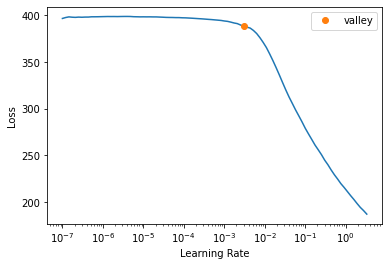

In [47]:
learner.lr_find()

In [48]:
learner.fit(7,lr=1e-2)

epoch,train_loss,valid_loss,None,time
0,141.143234,84.225197,2.643170,00:00
1,96.912926,84.202576,2.525887,00:00
2,83.412582,84.189133,2.517029,00:00
3,77.681038,84.180222,2.514067,00:00
4,75.013565,84.207909,2.525505,00:00
5,74.211884,84.210976,2.516829,00:00
6,73.132370,84.211906,2.517042,00:00


In [54]:
learner.fit(7,lr=1e-2,wd=0.001)

epoch,train_loss,valid_loss,None,time
0,144.199249,134.515213,3.980408,00:00
1,103.687386,134.205414,3.906922,00:00
2,70.592674,23.312109,1.097345,00:00
3,51.474846,23.244366,1.020593,00:00
4,42.605301,23.230288,0.983078,00:00
5,38.060112,23.219147,0.966697,00:00
6,35.383945,23.225288,0.948813,00:00


The model with Entity Embedding didnt performed better than the one without.

Model with entity embedding = MAE is 0.2364933


Model without entity embedding = MAE is 0.272

In [ ]:
preds, targs = learner.get_preds()

In [ ]:
MAE(targs,preds)

0.27265432

##### Random Forest

In [59]:
df.head()

,Item Promo Discount,price,Quantity,Invoice Amount,...,Is_year_end_2,Is_year_start_0,Is_year_start_1,Is_year_start_2
0,0.00,1995.00,1.0,1995.00,...,-0.249886,0.247412,-0.247902,-0.147692
1,-56.75,1078.25,1.0,1078.25,...,-0.249886,0.247412,-0.247902,-0.147692
2,-79.95,1519.05,1.0,1519.05,...,-0.249886,0.247412,-0.247902,-0.147692
3,0.00,1135.00,1.0,1135.00,...,-0.249886,0.247412,-0.247902,-0.147692
4,0.00,1499.00,1.0,1499.00,...,-0.249886,0.247412,-0.247902,-0.147692


In [60]:
procs = [Categorify, FillMissing]

In [61]:
dep_var = 'Quantity'

In [62]:
cont, cat = cont_cat_split( df,1,dep_var= dep_var)

We will use the splits that is defined earlier (also we have dropped the year column, so we cannot use it to create the splits)

In [64]:
to = TabularPandas(df, procs= procs,cat_names= cat, cont_names=cont, splits= splits,y_names=dep_var)

In [65]:
x_train,y_train = to.train.xs, to.train.y
x_valid, y_valid = to.valid.xs, to.valid.y

In [66]:
def rf(xs, y, n_estimators=40,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [67]:
rf =rf(x_train,y_train)

In [68]:
MAE(y_valid,rf.predict(x_valid))

0.03365301991101802

The Model performance without embedding is - 0.02807

The Model performance with embedding is    - 0.028

### Visualizing Embeddings 

In [18]:
import pickle
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [24]:
hours = df_main['hour'].unique() # we have to load the df_main again
hours

array([12., 20., 22., 10.,  0., 17., 13., 14., 16., 18., 11., 21.,  9.,  7.,  2., 15., 23., 19.,  8.,  3.,  6.,  1.,  4.,  5.])

In [ ]:
df.columns

Index(['Item Promo Discount', 'price', 'Quantity', 'Invoice Amount',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed', 'Asin_0',
       'Asin_1', 'Asin_2', 'Asin_3', 'Asin_4', 'Asin_5', 'Asin_6', 'Asin_7',
       'Asin_8', 'Asin_9', 'Asin_10', 'Asin_11', 'Asin_12', 'Asin_13',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'Dayofweek_0', 'Dayofweek_1',
       'Dayofweek_2', 'Dayofweek_3', 'Dayofweek_4', 'Month_0', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Day_0', 'Day_1', 'Day_2',
       'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10',
       'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6',
       'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12',
       'Week_13', 'Year_0', 'Year_1', 'Year_2'],
      dtype='object')

In [25]:
hour_embedding = df[['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9']]

In [52]:
emb = learner_emb.model.embeds[1]

In [53]:
emb(tensor(hours, dtype=torch.int64))

RuntimeError: ignored

In [29]:
hour_embedding.values.shape

(10946, 10)

In [ ]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
Y = tsne.fit_transform(hour_embedding.values)
plt.figure(figsize=(15,15))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(hours):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.savefig('hours.pdf')


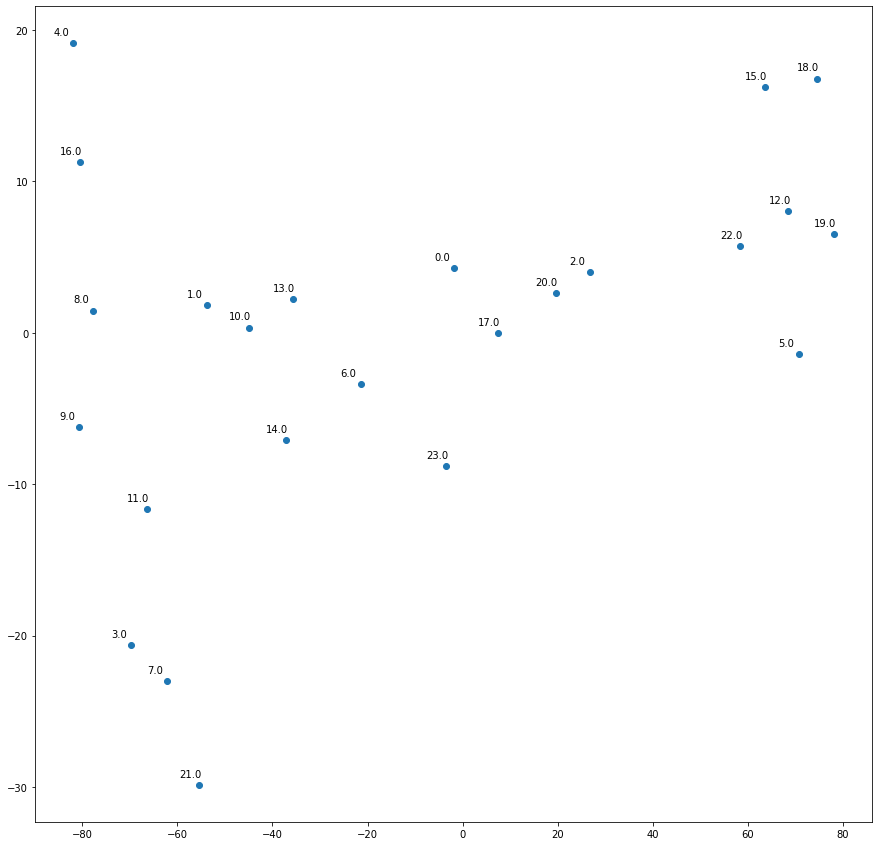

In [ ]:


tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
Y = tsne.fit_transform(hour_embedding)
plt.figure(figsize=(15,15))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(hours):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.savefig('hours.pdf')

